Dentro de vs_release_16k.zip descomprimimos dos carpetas:  
- audio_16k  
- meta  

Nos servimos del módulo zipfile para descomprimir y adicionalmente del módulo concurrent para utilizar threads agilizando la descompresión.  
https://superfastpython.com/multithreaded-unzip-files/#Unzip_Files_Concurrently_with_Processes

In [1]:
import os
from zipfile import ZipFile

zip_file_name = "vs_release_16k.zip"
dirs_to_extract = ["audio_16k", "meta"]
output_dir = "data"

if not os.path.exists(output_dir):
    with ZipFile(zip_file_name, 'r') as zf:
        files_to_extract = [file for file in zf.namelist()
                            if any(file.startswith(dir) for dir in dirs_to_extract)]
        zf.extractall(path=output_dir, members=files_to_extract)

print(os.listdir(output_dir))

['audio_16k', 'meta']


Ahora pasamos los datos a numpy arrays para poder trabajar con ellos:

In [4]:
import os
import wave
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

def read_wav_file(wav_file):
    with wave.open(wav_file, 'rb') as wf:
        num_frames = wf.getnframes()
        frames = wf.readframes(num_frames)
        wave_array = np.frombuffer(frames, dtype=np.int16)
        wave_name = os.path.basename(wav_file)
        wave_name = os.path.splitext(wave_name)[0]
    return wave_name, wave_array

base_dir = "data"
dir = "audio_16k"

audio_dir = os.path.join(base_dir, dir)
audios = os.listdir(audio_dir)
audio_paths = [os.path.join(audio_dir, file) for file in audios]

with ThreadPoolExecutor() as exe:
    results = list(exe.map(read_wav_file, audio_paths))

results[0:5]

[('m2231_0_throatclearing',
  array([ 18,  38,  16, ..., 135,  95, 101], dtype=int16)),
 ('m2007_0_cough', array([-2, -1, -2, ...,  7, 11, 15], dtype=int16)),
 ('f0086_0_sneeze', array([ 1, -1,  0, ...,  0,  0, -1], dtype=int16)),
 ('m2479_0_laughter', array([ 0,  9, 12, ...,  1,  3,  2], dtype=int16)),
 ('m1980_0_sniff',
  array([ 118, -148,  114, ...,   51,   36, -113], dtype=int16))]

Observación: Nuestros threads acceden a elementos distintos por tanto no hay problemas de race condition.

f0003_0_cough.wav  
f -> female  
(o -> old? check transcripted)  
cough -> one of the 6 labels  
0 -> index of that cough (individuals may have more than 1 cough registered)

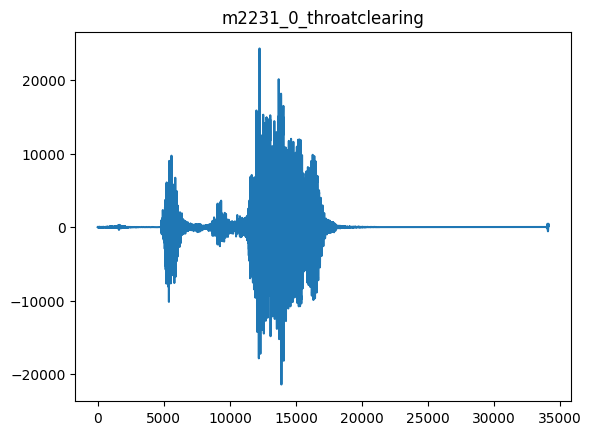

In [3]:
import matplotlib.pyplot as plt
name, arr = results[0]
plt.plot(arr)
plt.title(name)
plt.show()

In [5]:
import pandas as pd
df = pd.DataFrame(results, columns=['id', 'data'])
df.head()

,id,data
0,m2231_0_throatclearing,"[18, 38, 16, -1, 6, -5, -22, -7, -4, 2, 7, -3,..."
1,m2007_0_cough,"[-2, -1, -2, -1, 1, 1, 5, 3, 5, 1, 2, 1, -2, 3..."
2,f0086_0_sneeze,"[1, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,..."
3,m2479_0_laughter,"[0, 9, 12, 7, 3, 0, -2, -8, -19, -14, -14, -20..."
4,m1980_0_sniff,"[118, -148, 114, -58, -3, 40, -21, 67, 4, 72, ..."


In [6]:
df.loc[:, 'id'].str.split('_')

0        [m2231, 0, throatclearing]
1                 [m2007, 0, cough]
2                [f0086, 0, sneeze]
3              [m2479, 0, laughter]
4                 [m1980, 0, sniff]
                    ...            
21019          [f1369, 0, laughter]
21020              [m2016, 0, sigh]
21021    [m2565, 1, throatclearing]
21022            [m0266, 0, sneeze]
21023             [f3235, 0, sniff]
Name: id, Length: 21024, dtype: object